In [1]:
# ROM for 2D Building induced turbulence (turbulent kinetic energy)
    # with POD coefficient parameterized for wind direction.
    
# Details of database : 
    # Six Wind directions : [90,22.5,360,200,180,270] #[E,NNE,N,SSW,S,W]
    #"2D plane mesh from 3D data"
    # Polygonal Mesh - Cells : 433086 , Points : 234314
    # TKE values range from 0 - 0.6 m2/s2.    
    
#For Flow reconstruction (see at end): Input needed : (a) wind direction in degrees, (2) Load POD modes,(c) Load Mean TKE, and (d) Load trained RBF interpolators to compute POD coefficient for given wind direction.

# ROM: TKE field reconstruction for 433086 cells for a wind direction (without loading times) should take less than 0.1 s.

# Load libraries 

In [2]:
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf #for regression.

import pyvista as vtki
import numpy as np
import os
import pandas as pd
%config Completer.use_jedi = False


import vtk
from vtk.numpy_interface import dataset_adapter
from vtk.numpy_interface import algorithms as algs

import sys
from os.path import isdir, isfile, join
from os.path import expanduser
import numpy as np
import re

import json
import pickle



import random
import time as timer
import pickle

import matplotlib.pyplot as plt
import os, sys

#from pyvistaqt import BackgroundPlotter
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#import tensorflow as tf

#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Dense, Input, concatenate
#from tensorflow.keras.layers import LSTM, Flatten, Reshape, Conv2D, Conv2DTranspose, Dropout

#from tensorflow.keras import backend as K
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import train_test_split


# Load Building CFD data and read/visualize using pyVista

In [3]:


#To generate snapshots for basis functions - run the following script in paraview 
#%run run_in_paraview_for_snapshotdataset

In [4]:
# tips for uniform grid and interpolationg from structured to unstructured
# https://github.com/pyvista/pyvista-support/issues/148 
# https://docs.pyvista.org/version/stable/examples/01-filter/resample#resampling-example

# https://discourse.vtk.org/t/creating-uniform-rectilinear-slice-of-3d-data/1002/2

In [5]:
#Filenames to load the data 
fnyaw_0= '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_8_mps_NorthWesterly/VTK/' #Prague_8_mps_NorthWesterly_3312.vtm 
#'/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings'
filenames=[fnyaw_0] 
print(filenames[0])

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_8_mps_NorthWesterly/VTK/


In [143]:
fnyaw_0= '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/' #Prague_8_mps_NorthWesterly_3312.vtm 
#'/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings'
filenames=[fnyaw_0] 
print(filenames[0])

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/


In [144]:
res=[]
for (root,dirs,files) in os.walk(fnyaw_0, topdown=True):
    for name in files:
        #print ((os.path.join(root, name)))
        #subs='U_zplane'
        #print(name)
        #break
        #res = [i for i in name if subs in os.path.join(root, name)]
        #print (root)
        #print (dirs)
        #print (files)
        #if name=='U_zplane.vtk':
        extensions = '.vtm'
        if (name.endswith(extensions)) & ("boundary" not in name):
            res.append(os.path.join(root, name))              
        

In [145]:
res.sort()

In [147]:
len(res)

32

In [146]:
res

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEasterly/VTK/Prague_0p5_mps_NorthEasterly_2702.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWesterly/VTK/Prague_0p5_mps_NorthWesterly_2716.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Northerly/VTK/Prague_0p5_mps_Northerly_3209.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthEasterly/VTK/Prague_0p5_mps_SouthEasterly_2882.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthWesterly/VTK/Prague_0p5_mps_SouthWesterly_2815.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Southerly/VTK/Prague_0p5_mps_Southerly_3998.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Westerly/VTK/Prague_0p5_mps_

In [148]:
grid = vtki.MultiBlock(res[0])

In [10]:
Unstructuredgrid=grid["internal"]

In [11]:
boundarygrid=grid["boundary"]

In [12]:
for name in grid.keys():
    print(name)
    #block = blocks[name]

internal
boundary


In [13]:
Unstructuredgrid

UnstructuredGrid (0x7fb3444f0340)
  N Cells:    8015791
  N Points:   8925729
  X Bounds:   9.800e+02, 1.980e+03
  Y Bounds:   -2.570e+03, -1.670e+03
  Z Bounds:   1.656e+01, 4.500e+02
  N Arrays:   11

In [14]:
Unstructuredgrid['k']
Unstructuredgrid['U']

pyvista_ndarray([[-0.18560544, -1.8760011 , -0.17783496],
                 [-0.16743197, -2.8176863 , -0.29778895],
                 [-0.15329129, -2.8866186 , -0.34160244],
                 ...,
                 [-6.765383  , -5.950899  ,  0.81826353],
                 [-6.7409782 , -5.948168  ,  0.81499314],
                 [-6.7597938 , -5.904741  ,  0.8363579 ]], dtype=float32)

In [15]:
boundarygrid

MultiBlock (0x7fb3444f0460)
  N Blocks    6
  X Bounds    980.000, 1980.000
  Y Bounds    -2570.013, -1669.986
  Z Bounds    16.558, 450.000

In [16]:
xmin=980.0
ymin=-2570.013
zmin=16.558
xmax=1980.0000
ymax=-1669.986
zmax=300.00

In [17]:
unstructured_grid=Unstructuredgrid.clip_box([xmin, xmax, ymin, ymax, zmin, zmax],invert=False)

In [18]:
unstructured_grid

UnstructuredGrid (0x7fb3444f04c0)
  N Cells:    45098316
  N Points:   8759960
  X Bounds:   9.800e+02, 1.980e+03
  Y Bounds:   -2.570e+03, -1.670e+03
  Z Bounds:   1.656e+01, 3.100e+02
  N Arrays:   11

In [19]:
unstructured_grid.save('unstructuredgrid_clipped.vtk')

In [20]:
#filename = 'LSBU_100.vtu'
#mesh = pv.read(filename)

size = 50
x = np.linspace(xmin, xmax, size)
y = np.linspace(ymin, ymax, size)
z = np.linspace(zmin, zmax, size)
x, y, z = np.meshgrid(x, y, z)

# Create the unstructured grid directly from the numpy arrays and plot
grid_structured = vtki.StructuredGrid(x, y, z)
#result = grid2.interpolate(grid, radius=5.)

# Resample back to unstructured mesh
#foo = mesh.copy()
#foo.clear_arrays()
#result2 = foo.sample(result)

#p = pv.Plotter(notebook=False, shape=(1,3))
#p.add_mesh(mesh, show_edges=0)
#p.subplot(0,1)
#p.add_mesh(result, show_edges=0)
#p.subplot(0,2)
#p.add_mesh(result2, show_edges=0)
#p.link_views()
#p.show()

In [21]:
#we dont need sample.
result_sample = grid_structured.sample(unstructured_grid)

In [329]:
#Avoid using interpolate for CFD dataset. Dont use this.
result_interpolate= grid_structured.interpolate(unstructured_grid,strategy='mask_points')
result_interpolate.save('Utest_interpolate.vtk')

In [23]:
type(unstructured_grid)

pyvista.core.pointset.UnstructuredGrid

In [24]:
result_sample

StructuredGrid (0x7fb3444f0d60)
  N Cells:      117649
  N Points:     125000
  X Bounds:     9.800e+02, 1.980e+03
  Y Bounds:     -2.570e+03, -1.670e+03
  Z Bounds:     1.656e+01, 3.000e+02
  Dimensions:   50, 50, 50
  N Arrays:     8

In [330]:
result_sample.save('Utest_sample.vtk')

In [27]:
# points=.points

In [28]:
# points.shape

In [29]:
for name in boundarygrid.keys():
    print(name)


west
south
north
east
top
terrain6


In [30]:
boundarygrid_terrain6=boundarygrid["terrain6"]

In [31]:
boundarygrid_terrain6

PolyData (0x7fb3444f0dc0)
  N Cells:    890094
  N Points:   912193
  N Strips:   0
  X Bounds:   9.800e+02, 1.980e+03
  Y Bounds:   -2.570e+03, -1.670e+03
  Z Bounds:   1.656e+01, 1.485e+02
  N Arrays:   11

result_sample['k'].ravel(order='F')

charname=['k','U']
my_dict = {}
for i in charname:  
    my_dict[i] = list([]) 

type(my_dict['k'])

my_dict['k'].append(10)
my_dict['k'].append(20)

my_dict['k']=np.stack(my_dict['k'],axis=0)

type(my_dict['k'])

In [ ]:
# grid.cell_data.set_vectors(tmp3[:,i].reshape(-1, 3, order='F'),"AE_Rey_Vel_"+str(int(Re))+"_"+str(i))

In [88]:
# Utemp=result_sample['U'].ravel(order='F')

375000

In [261]:
res[:8]

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEasterly/VTK/Prague_0p5_mps_NorthEasterly_2702.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWesterly/VTK/Prague_0p5_mps_NorthWesterly_2716.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Northerly/VTK/Prague_0p5_mps_Northerly_3209.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthEasterly/VTK/Prague_0p5_mps_SouthEasterly_2882.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthWesterly/VTK/Prague_0p5_mps_SouthWesterly_2815.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Southerly/VTK/Prague_0p5_mps_Southerly_3998.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Westerly/VTK/Prague_0p5_mps_

In [338]:
def generate_data(res,grid_structured,charname=['k','U']):  
    my_dict = {}
    for i in charname:
        my_dict[i] = list([])    
           
    # Ut11=[]
    for filename in res:
        print(filename) 
        #loop on files 
        # Utemp1=[]       
        
        # grid =  #Read data in a file PolyData           
                
        unstructured_grid=vtki.MultiBlock(filename)["internal"]
        
        unstructured_grid=unstructured_grid.clip_box([xmin, xmax, ymin, ymax, zmin, zmax],invert=False)


        print('creating TRAINING data for filename',filename)
        #print(charname,type(charname),type('k'))
        
        
        result_sample1 = grid_structured.sample(unstructured_grid)
        
        for charnames in charname:  #charname
             
            Utemp1=result_sample1[charnames].ravel(order='F') #Flattened pyvista array 1D for TKE field using ravel.         
                          
            my_dict[charnames].append(np.array(Utemp1)) #convert pyvista to numpy array and append to the list charname in the dictionary. So dictionary has keys with list of arrays.
            print(charnames,type(Utemp1),Utemp1.shape,type(my_dict[charnames])) #Utemp1.shape
            del Utemp1
            #Ut11.append(Utemp1)
        del result_sample1
    #LOOP OVER TIME STEP ENDS HERE. 
    # At the end of loop - We have a "list of arrays". The length of list= total number of arrays = "num_times", 
    # and each of these array is of size num_grid_size. 

    #CREATE 2D ARRAY FROM ABOVE LIST OF ARRAYS.
    #Below we use numpy stack, to combine list of arrays 
    #in such a way that each array in the list is added as new feature (as new column).
    
    #print('lenUt11',len(Ut11))
        
        # U1=np.stack(Ut11,axis=1)   #it joins arrays from list of arrays.Dimensions along column a new axis.
       
    #for charname in charname:
        #print(type(my_dict[charname])) 
        #my_dict[charname]= np.stack(my_dict[charname],axis=1) #All arrays from list gets stacked as new column at axis=1. 
        #print(type(my_dict[charname]))    
        #U1=np.stack(my_dict[charname],axis=1)
    
    return my_dict

# Load all building data

In [353]:
all_prague_data_structued_dict=generate_data(res,grid_structured) 
Uall=np.stack(all_prague_data_structued_dict['U'])
kall=np.stack(all_prague_data_structued_dict['k'])
np.save('kall_building_prague_0p5mps.npy',kall)
np.save('Uall_building_prague_0p5mps.npy',Uall)

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm
creating TRAINING data for filename /media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm
k <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (125000,) <class 'list'>
U <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (375000,) <class 'list'>
/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEasterly/VTK/Prague_0p5_mps_NorthEasterly_2702.vtm
creating TRAINING data for filename /media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEasterly/VTK/Prague_0p5_mps_NorthEasterly_2702.vtm
k <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (125000,) <class 'list'>
U <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (375000,) <class 'list'>
/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWesterly/VTK/Prague_0p5_mps_Nor

In [354]:
Uall.shape

(32, 375000)

In [355]:
kall.shape

(32, 125000)

In [263]:
my_dict=generate_data(res[:8],grid_structured) #charname is default.

/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm
creating TRAINING data for filename /media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm
(125000,)
k <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (125000,) <class 'list'>
(375000,)
U <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (375000,) <class 'list'>
/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEasterly/VTK/Prague_0p5_mps_NorthEasterly_2702.vtm
creating TRAINING data for filename /media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEasterly/VTK/Prague_0p5_mps_NorthEasterly_2702.vtm
(125000,)
k <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (125000,) <class 'list'>
(375000,)
U <class 'pyvista.core.pyvista_ndarray.pyvista_ndarray'> (375000,) <class 'list'>
/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_

for charnames in charname:
        #print(type(my_dict[charname])) 
        if charnames=='U':
                U= np.stack(my_dict[charnames],axis=0) #All arrays from list gets stacked as new column at axis=1. 
        else:
                k= np.stack(my_dict[charnames],axis=1)
        #print(type(my_dict[charname]))    
        

In [264]:
U=np.stack(my_dict['U'])

In [265]:
U.shape

(8, 375000)

In [266]:
k=np.stack(my_dict['k'])

In [267]:
k.shape

(8, 125000)

# Save building data

In [268]:
np.save('k_building_prague_0p5mps.npy',k)
np.save('U_building_prague_0p5mps.npy',U)

In [269]:
k.shape #num_spatial x num_times

(8, 125000)

In [270]:
k.max()

1.0822

In [271]:
k.min()

0.0

In [340]:
grid_structured

StructuredGrid (0x7fb3444f0c40)
  N Cells:      117649
  N Points:     125000
  X Bounds:     9.800e+02, 1.980e+03
  Y Bounds:     -2.570e+03, -1.670e+03
  Z Bounds:     1.656e+01, 3.000e+02
  Dimensions:   50, 50, 50
  N Arrays:     10

In [273]:
type(grid)

pyvista.core.composite.MultiBlock

In [274]:
k1=k.T

# Define all POD functions

In [275]:
#POD functions

nd,ns = k1.shape
nr=np.min([10,ns])

def POD_svd(tdata,nr):
    
    nd,ns = tdata.shape #nd=grid, ns=1 or wind direction (instead of time).
    
    
       
    #mean subtraction
    
    tm = np.mean(tdata) #tdata,axis=1, Use axis when 3D, and generating basis for each parameter.
    #um = np.mean(Au,axis=1)
    
    
    At = tdata - tm #.reshape([-1,1])
    
    
    print('At',At.shape)
    
    #singular value decomposition : https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
    
    Ut, St, Vht = LA.svd(At, full_matrices=False)
    
   
    print('U',Ut.shape,'S',St.shape,'V',Vht.shape)
           
    Phit = Ut[:,:nr]  
    Lt = St**2
    
    #compute RIC (relative importance index)
    RICt = np.cumsum(Lt)/np.sum(Lt)*100
    
    print('Phit',Phit.shape,'Lt',Lt.shape)
    return tm,Phit,Lt,RICt 

def PODproj_svd(u,Phi): #Projection
    a = np.dot(Phi.T,u)  # u = Phi * a if shape of a is [nr i.e num_modes,ns i.e num_winddirection]
    return a

def PODrec_svd(a,Phi): #Reconstruction    
    u = np.dot(Phi,a)    
    return u







###############################################################################
#POD Routines without mean
###############################################################################         
def POD(u,R): #Basis Construction
    n,ns = u.shape
    U,S,Vh = LA.svd(u, full_matrices=False)
    Phi = U[:,:R]
    L = S**2
    #compute RIC (relative inportance index)
    RIC = sum(L[:R])/sum(L)*100   
    
    return Phi,L,RIC

def PODproj(u,Phi): #Projection
    a = np.dot(u.T,Phi)  # u = Phi * a.T
    return a

def PODrec(a,Phi): #Reconstruction    
    u = np.dot(Phi,a.T)    
    return u


In [276]:
import numpy.linalg as LA

# Obtain POD basis functions for turbulent kinetic energy and velocity

In [428]:
def save_csv_reconstructed (grid2,variable,wind_dir,fn,vectorU):
    
    #print("Turbine located at around Y=1500, X=1000 in figure below")
    data = {'X': grid2.points[:, 0],    #cell_centers.points
            'Y': grid2.points[:, 1],
            'Z': grid2.points[:, 2],
        }
    df = pd.DataFrame(data)

#Suggest Time for reconstruction in arange below. 
#To reconstruct at all time-steps and save images, start loop from 0.

    if vectorU==False:        
        turbke=grid2["RECON_tke_at_WD_"+str(wind_dir)]
        data2 = {'tke':turbke}
        df=df.join(pd.DataFrame(data2))
    else:
        vel=grid2["RECON_U_at_WD_"+str(wind_dir)]  #tke_at_wind_direction.reshape(-1, 3, order='F')
        data2 = {'Velocity_X_': vel[:, 0],'Velocity_Y_': vel[:, 1],'Velocity_Z_': vel[:, 2],'tke':turbke}
        df=df.join(pd.DataFrame(data2))            
        
       
        # saveimage(i)

# Save CSV    
    csv_file = fn+'/'+ f'variable'+'_'+str(wind_dir)+'_Output.csv'     
    df.to_csv(csv_file, index=False)
    print(f"CSV file saved successfully: {csv_file}")

    return df 
#Save Grid
#grid2.save(fn+'/Velocity_reconstruction_stored.vtk')
#grid2.save(fn+'/Velocity_reconstruction_stored.vtu') 
    


In [417]:
def train_AI_for_winddirection(variable,variable_name,num_modes,vectorU=True): #variable : num_grid x num_wind_directions
    import numpy as np
    #Obtain basis functions (most dominant spatial patterns) #Phit : num_grid x num_basis (=num_modes)
    tm,Phit,Lt,RICt=POD_svd(variable,num_modes)
    
    #Obtain coefficient (function of wind diretion) #tcoeff
    k1_wo_mean = variable-tm 
    tcoeff = PODproj_svd(k1_wo_mean,Phit)
    
    #Save variance captured by mode
    fig = plt.figure()
    plt.plot(range(1,num_modes+1),np.cumsum(Lt)/sum(Lt)*100)
    fig.suptitle('Energy in '+ f'{variable_name}'+' basis modes', fontsize=22)
    plt.xlabel('Modes ', fontsize=22)
    plt.ylabel('Cumulative Energy, %', fontsize=22)
    fig.savefig(fn+'/'+f'{variable_name}'+'_Cumulative_Energy.png')
    fig.savefig(fn+'/'+f'{variable_name}'+'_Cumulative_Energy.pdf') 
    
    # Save POD modes for viewing
    if vectorU==False:        
        for i in range(num_modes): #nr , first 5 modes saved.
            result_sample.point_data[f'{variable_name}'+"_mode_"+str(i)]=Phit[:,i]
    else:
         for i in range(num_modes): #nr , first 5 modes saved.
            Phi_reshaped=Phit[:,i].reshape(-1, 3, order='F')          
            result_sample.point_data.set_vectors(Phi_reshaped,"Phi_U_"+str(i))
            del Phi_reshaped
            
                 
    # Save POD data and VTK files to be used later for reconstruction
    folder = 'data_POD' #str(nx) + '_' + str(ny)       
    
    if not os.path.exists('./Results/'+folder):
        os.makedirs('./Results/'+folder)
        
    filename = fn+'/POD_data_' +f'{variable_name}'+'.npz'
    np.savez(filename, tmean=tm, tbasis=Phit,tcoeff=tcoeff,teigenvalues=Lt,tric=RICt) 
    
    #Input wind direction used in training dataset for AI
    input_feature=[90,45,315,360,135,225,180,270]
    data=np.array(input_feature)
    max_value=360
    xsin1=np.sin(2 * np.pi * data / max_value)
    xcos1=np.cos(2 * np.pi * data / max_value)
        
    import numpy as np
    from scipy.interpolate import Rbf
    import pickle


    # Create Rbf interpolators for coefficients associated with each mode. Then 
    interpolators = []
    for i in range(nr):
        rbf = Rbf(xsin1,xcos1,tcoeff[i,:],function='multiquadric') 
        interpolators.append(rbf)

    # Save the Rbf interpolators to a file
    with open('./Results/'+folder+'/'+f'{variable_name}'+'_rbf_interpolators.pkl', 'wb') as file:
        pickle.dump(interpolators, file)  
    
    return tm, Phit, interpolators,result_sample #mean_of_variable,basis_functions,Coefficient_interpolators     
    
    

In [406]:

import time
import random
import time
import pyvista as pv
import pandas as pd
import numpy as np
#from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable

#wind_direc=[270] or wind_direc=[270,200,230]
wind_direc = [random.randint(0, 360) for _ in range(5)]
print(wind_direc)

fn=os.path.abspath("./Results/data_POD")

def reconstruct_AI_for_winddirection(variable,wind_direc,num_modes,fn,vectorU=True):    
    
    start = time.process_time()
    # your code here    
    # Assume a wind direction 
    # wind_dir=np.rand270 #in degrees
    folder = 'data_POD'
    
    # Load the Rbf interpolators from a file
    print(fn+'/'+f"{variable}"+'_rbf_interpolators.pkl')
    with open(fn+'/'+f"{variable}"+'_rbf_interpolators.pkl', 'rb') as file:
        loaded_interpolators = pickle.load(file)
        
        
    #Obtain basis functions : Load saved basis functions (modes) and mean turbulent kinetic energy
    #----------------------------------------------------------------------------------------------.     
    filename = fn+'/POD_data_' +f"{variable}"+'.npz'    
        
    PODdata=np.load(filename)

    Phit=PODdata['tbasis']
    tke_mean=PODdata['tmean']    

    for wind_dir in wind_direc:     
        
        #Obtain coefficient for this wind direction
        #------------------------------------------------------------------  
        # Interpolate using the loaded interpolators (for demonstration)
        predicted_coef = []
        max_value=360
        xsin_winddir=np.sin(2 * np.pi * wind_dir / max_value)
        xcos_winddir=np.cos(2 * np.pi * wind_dir / max_value)
        for i, rbf1 in enumerate(loaded_interpolators):
            predicted_coef.append(rbf1(xsin_winddir,xcos_winddir))
            print('Coeff for mode', i+1 , 'is ', rbf1(xsin_winddir,xcos_winddir))

       #Reconstruct flow field from the basis modes, the mean and the computed coefficients
        #----------------------------------------------------------------------------------------------------
        tke_at_wind_direction=np.dot(Phit,np.array(predicted_coef))+tke_mean

        #Visualize reconstructed flow field.
        #----------------------------------------------------------------------------------------------------
        if vectorU==False:
            result_sample.point_data["RECON_tke_at_WD_"+str(wind_dir)]=tke_at_wind_direction
        else:
            U_reshaped=tke_at_wind_direction.reshape(-1, 3, order='F') 
            result_sample.point_data.set_vectors(U_reshaped,"RECON_U_at_WD_"+str(wind_dir))
            
        result_sample.save('./Results/recon_added_' +f"{variable}"+'.vtk')
        df=save_csv_reconstructed(result_sample,variable,wind_dir,fn,vectorU)      
    #Print time taken
    print(time.process_time() - start)
        
    return result_sample,time.process_time() - start

[137, 58, 166, 216, 299]


In [357]:
U.shape

(8, 375000)

# Velocity from AI

At (375000, 8)
U (375000, 8) S (8,) V (8, 8)
Phit (375000, 8) Lt (8,)


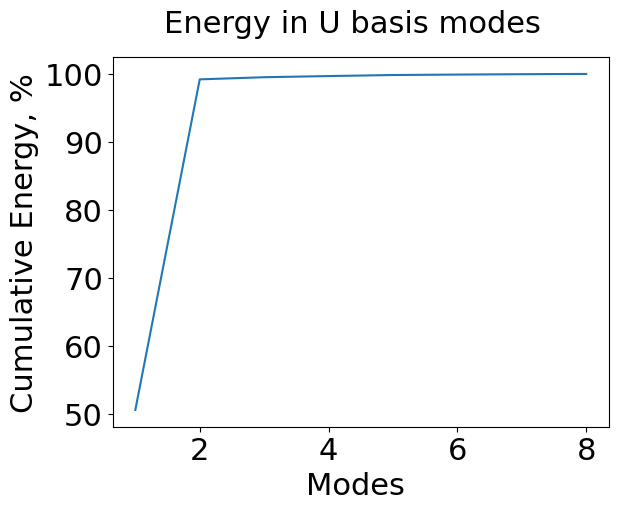

In [418]:
Um, PhiU, interpolators_U,result_sample1=train_AI_for_winddirection(U.T,'U',nr)

In [ ]:
# Test Velocity for wind direction

In [419]:
wind_direc = [random.randint(0, 360) for _ in range(5)]
print(wind_direc)
result_samples1,timetaken=reconstruct_AI_for_winddirection("U",wind_direc,nr,fn,vectorU=True)
#result_sample1.save('./Results/recon_added_' +'f{variable}'+'.vtk')

[106, 136, 123, 110, 72]
/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/U_rbf_interpolators.pkl
Coeff for mode 1 is  129.96762260544187
Coeff for mode 2 is  -133.93785977505877
Coeff for mode 3 is  -12.432479489133975
Coeff for mode 4 is  8.737247880432278
Coeff for mode 5 is  3.6948385849529615
Coeff for mode 6 is  -0.6562939574696287
Coeff for mode 7 is  -5.440603422258114
Coeff for mode 8 is  1.02254100477262
Coeff for mode 1 is  177.76890084862248
Coeff for mode 2 is  -49.68119886413503
Coeff for mode 3 is  -6.820414990245425
Coeff for mode 4 is  0.3540472155911374
Coeff for mode 5 is  11.783445336809926
Coeff for mode 6 is  -7.222608993208263
Coeff for mode 7 is  0.4469777975053546
Coeff for mode 8 is  -3.4781478734301743


Coeff for mode 1 is  162.51469073699593
Coeff for mode 2 is  -88.79731374114152
Coeff for mode 3 is  -9.059657813667549
Coeff for mode 4 is  4.732502619175953
Coeff for mode 5 is  9.221218224290013
Coeff for mode 6 is  -6.0074828534513
Coeff for mode 7 is  -2.5337763278007586
Coeff for mode 8 is  -2.683301209641826
Coeff for mode 1 is  138.8112125440465
Coeff for mode 2 is  -124.18555853145844
Coeff for mode 3 is  -11.659725394702932
Coeff for mode 4 is  8.07059046437194
Coeff for mode 5 is  5.102219299861716
Coeff for mode 6 is  -2.0679374699126853
Coeff for mode 7 is  -4.995855141897387
Coeff for mode 8 is  0.10465591845391486
Coeff for mode 1 is  30.968769333860905
Coeff for mode 2 is  -184.08662391346354
Coeff for mode 3 is  -15.655496774709995
Coeff for mode 4 is  4.395447114773809
Coeff for mode 5 is  -5.812558246604084
Coeff for mode 6 is  5.055186087889112
Coeff for mode 7 is  0.4617181799524559
Coeff for mode 8 is  1.1345066404377349
3.2279121600004146


At (125000, 8)
U (125000, 8) S (8,) V (8, 8)
Phit (125000, 8) Lt (8,)


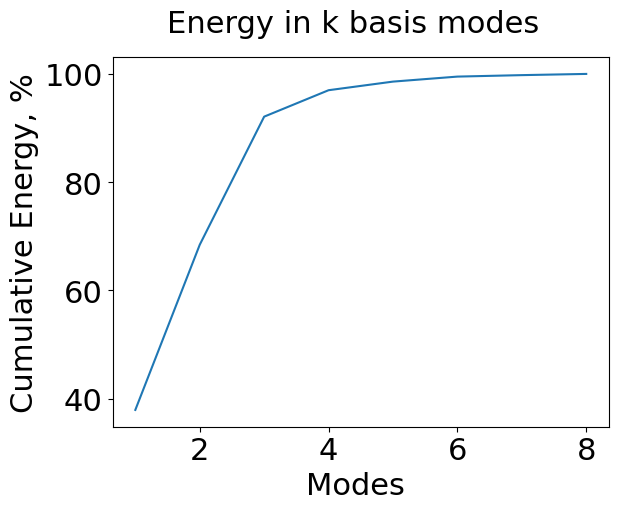

In [420]:
km, kU, interpolators_k,result_sample_k=train_AI_for_winddirection(k.T,'k',nr,vectorU=False)

In [421]:
fn

'/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD'

In [422]:
wind_direc = [random.randint(0, 360) for _ in range(5)]
print(wind_direc)
result_samples_k,timetaken=reconstruct_AI_for_winddirection("k",wind_direc,nr,fn,vectorU=False)

[233, 210, 237, 109, 296]
/media/mandart/D/AI4Hydrop_Prague/ROM/Results/data_POD/k_rbf_interpolators.pkl
Coeff for mode 1 is  59.45434251101051
Coeff for mode 2 is  51.96429353875039
Coeff for mode 3 is  -40.53234378952354
Coeff for mode 4 is  -5.8891800788932755
Coeff for mode 5 is  -7.231217396624686
Coeff for mode 6 is  -9.999615560235789
Coeff for mode 7 is  1.8096184912110687
Coeff for mode 8 is  4.825599690748916
Coeff for mode 1 is  51.256924911243004
Coeff for mode 2 is  33.81346630863872
Coeff for mode 3 is  -52.19938819757776
Coeff for mode 4 is  13.737958985228943
Coeff for mode 5 is  -4.053660602258958
Coeff for mode 6 is  -9.027736489319814
Coeff for mode 7 is  5.097782897566745
Coeff for mode 8 is  0.8251815239790545
Coeff for mode 1 is  58.05873636331603
Coeff for mode 2 is  53.93173064796201
Coeff for mode 3 is  -37.45191261911398
Coeff for mode 4 is  -9.060020609124933
Coeff for mode 5 is  -5.256399822621006
Coeff for mode 6 is  -9.586090422074303
Coeff for mode 7 is  

In [423]:
result_samples_k.save('./Results/recon_added_' +'k_var'+'.vtk')

In [ ]:
#Below is code for k
# Things to do :

#Test the above function for tke_at_wind_dire
#Save reconstructed into format X,Y,Z,U,V,W,k using ROM_windturbine.ipynb
#Convert X,Y,Z into latl/long and UTM.
#Code to obtain U and k from the nearest chosen lat/long and UTM.


#Attempt to take feedback

# Do U and k for all wind speeds using windspeed as one of rbf interpolators


In [ ]:
save_csv_reconstructed (result_samples_k,variable_vector,variable_scalar,fn)

In [424]:
result_sample_k

StructuredGrid (0x7fb3444f0d60)
  N Cells:      117649
  N Points:     125000
  X Bounds:     9.800e+02, 1.980e+03
  Y Bounds:     -2.570e+03, -1.670e+03
  Z Bounds:     1.656e+01, 3.000e+02
  Dimensions:   50, 50, 50
  N Arrays:     45

In [277]:
tm,Phit,Lt,RICt=POD_svd(k1,nr) #mean tke, tke basis functions (modes) , magnitude (energy) , relative importance of modes. 

At (125000, 8)
U (125000, 8) S (8,) V (8, 8)
Phit (125000, 8) Lt (8,)


In [278]:
Phit.shape

(125000, 8)

# 

# Obtain POD true coefficients 
#### by projecting the data (without the mean) on the basis functions
##### for turbulent kinetic energy

In [279]:
k1_wo_mean = k1-tm

tcoeff = PODproj_svd(k1_wo_mean,Phit)

In [280]:
tcoeff.shape

(8, 8)

### TKE mean value below

In [281]:
tm

0.18315797

In [282]:
# create plots folder
fn="./Plots1"
if os.path.isdir(fn):
    print('Plots folder already exists')
else: 
    print('Creating plots folder')
    os.makedirs(fn)

Plots folder already exists


# Plot variance/energy captured by modes

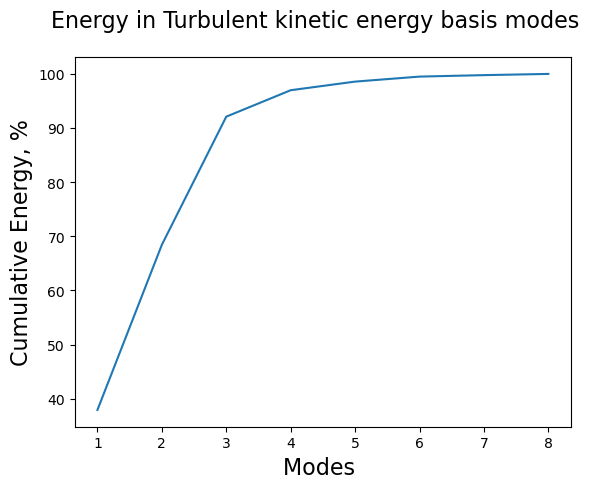

In [283]:
fig = plt.figure()
plt.plot(range(1,nr+1),np.cumsum(Lt)/sum(Lt)*100)
fig.suptitle('Energy in Turbulent kinetic energy basis modes', fontsize=16)
plt.xlabel('Modes ', fontsize=16)
plt.ylabel('Cumulative Energy, %', fontsize=16)
fig.savefig(fn+'/Cumulative_Energy_Velocity.png')
fig.savefig(fn+'/Cumulative_Energy_Velocity.pdf')

# Save all POD modes in VTK format for visualization in paraview

In [289]:
grid_structured

StructuredGrid,Information
N Cells,117649
N Points,125000
X Bounds,"9.800e+02, 1.980e+03"
Y Bounds,"-2.570e+03, -1.670e+03"
Z Bounds,"1.656e+01, 3.000e+02"
Dimensions,"50, 50, 50"
N Arrays,0


In [341]:
grid_structured.save('test.vtk')

In [291]:
for i in range(nr): #nr , first 5 modes saved.
    grid_structured.cell_data["TKE_mode_"+str(i)]=Phit[:,i]
    

In [294]:
#Note: Pyvisa visualization not working now. So, visualize in paraview.
grid_structured.point_data

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : TKE_mode_0
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    TKE_mode_0              float32    (125000,)            SCALARS
    TKE_mode_1              float32    (125000,)
    TKE_mode_2              float32    (125000,)
    TKE_mode_3              float32    (125000,)
    TKE_mode_4              float32    (125000,)
    TKE_mode_5              float32    (125000,)
    TKE_mode_6              float32    (125000,)
    TKE_mode_7              float32    (125000,)

#Important basis modes saved in new VTK files
grid.save('Basisadded.vtk')

In [295]:
nr,ns

(8, 8)

# Save POD data and VTK files

In [296]:
# Save POD data and VTK files

folder = 'data_POD' #str(nx) + '_' + str(ny)       

if not os.path.exists('./Results/'+folder):
    os.makedirs('./Results/'+folder)

filename = './Results/'+folder+'/POD_data_k.npz'
np.savez(filename, tmean=tm, tbasis=Phit,tcoeff=tcoeff,teigenvalues=Lt,tric=RICt)
    

In [320]:
Phit.shape

(433086, 6)

In [298]:
tcoeff.shape

(8, 8)

In [300]:
res[:8]

['/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Easterly/VTK/Prague_0p5_mps_Easterly_5000.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthEasterly/VTK/Prague_0p5_mps_NorthEasterly_2702.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_NorthWesterly/VTK/Prague_0p5_mps_NorthWesterly_2716.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Northerly/VTK/Prague_0p5_mps_Northerly_3209.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthEasterly/VTK/Prague_0p5_mps_SouthEasterly_2882.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_SouthWesterly/VTK/Prague_0p5_mps_SouthWesterly_2815.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Southerly/VTK/Prague_0p5_mps_Southerly_3998.vtm',
 '/media/mandart/D/AI4Hydrop_Prague/Prague_All_simulations/Prague_0p5_mps_Westerly/VTK/Prague_0p5_mps_

# Interpolate True Coefficient as function of wind direction using Radial basis function

In [301]:
input_feature=[90,45,315,360,135,225,180,270] #[E,NE,NW,N,SE,SW,S,W] wind direction is named after the direction from which the wind is coming.

In [302]:
# Wind direction is a cyclic feature . So convert it into a form required for  input feature into form required.


In [303]:
input_feature

[90, 45, 315, 360, 135, 225, 180, 270]

### Convert cyclic features

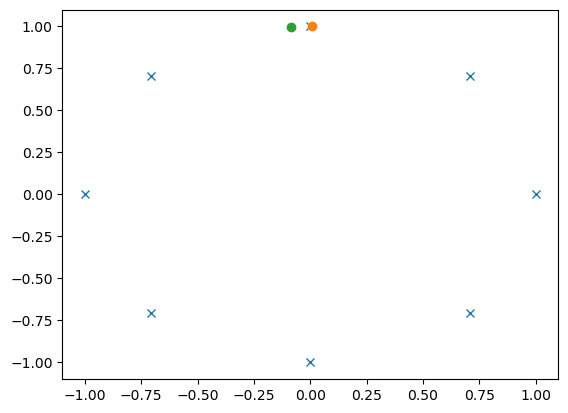

In [304]:
data=np.array(input_feature)
max_value=360
xsin1=np.sin(2 * np.pi * data / max_value)
xcos1=np.cos(2 * np.pi * data / max_value)
plt.plot(xsin1,xcos1,'x')
plt.plot(np.sin(2 * np.pi *(0.5/360)),np.cos(2 * np.pi *0.5/360),'o',label='0.5')
plt.plot(np.sin(2 * np.pi *(355/360)),np.cos(2 * np.pi *355/360),'o',label='355')
    

res

North (N): 0° = 360°
East (E): 90°
South (S): 180°
West (W): 270°
Intercardinal directions
The intercardinal (intermediate, or, historically, ordinal[2]) directions are the four intermediate compass directions located halfway between each pair of cardinal directions.

Northeast (NE), 45°, halfway between north and east, is the opposite of southwest.
Southeast (SE), 135°, halfway between south and east, is the opposite of northwest.
Southwest (SW), 225°, halfway between south and west, is the opposite of northeast.
Northwest (NW), 315°, halfway between north and west, is the opposite of southeast.


In [311]:

font = {'family' : 'sans-serif',
        'size'   : 22}

plt.rc('font', **font)

# Plot true coefficient as function of wind directions and save the figures

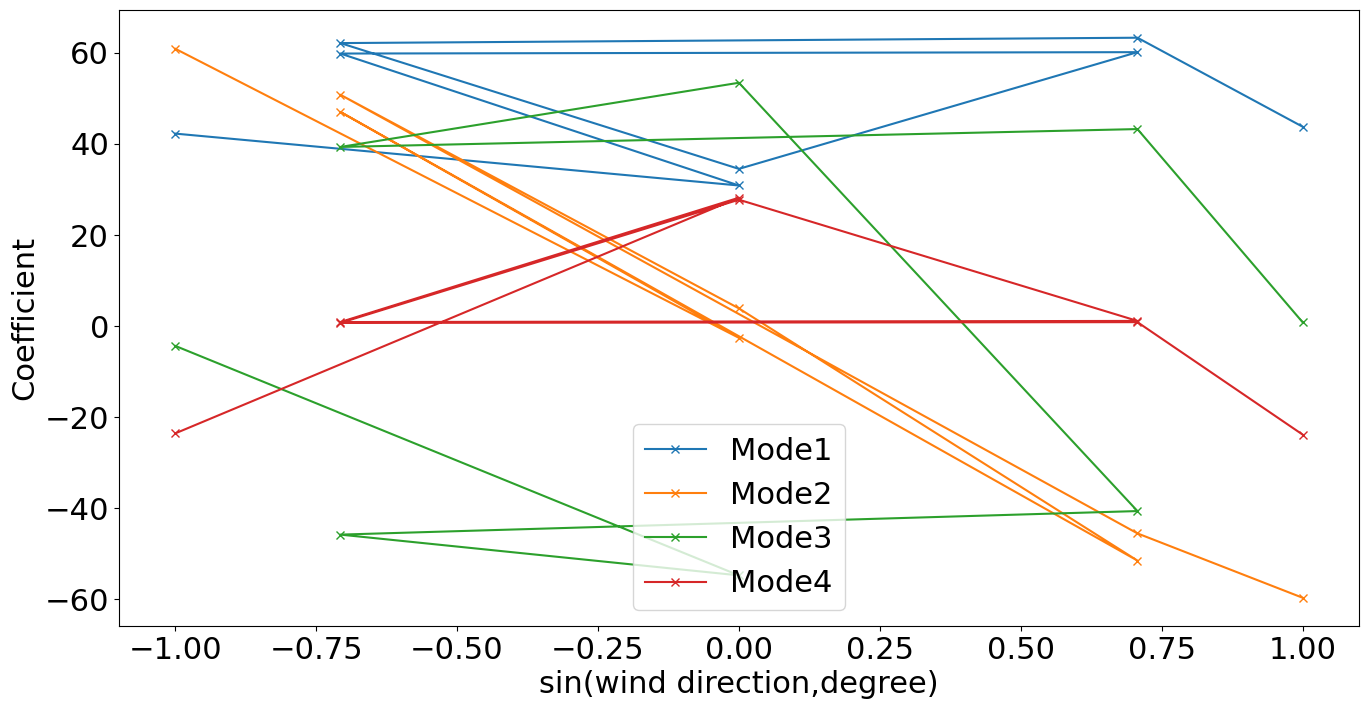

In [312]:
#tcoeff #modes x wind_direction
plt.figure(figsize=(16,8))
for i in range(4): #6
    plt.plot(xsin1,tcoeff[i,:],'x-',label='Mode'+str(i+1))
plt.xlabel('sin(wind direction,degree)')
plt.ylabel('Coefficient')
plt.legend()   

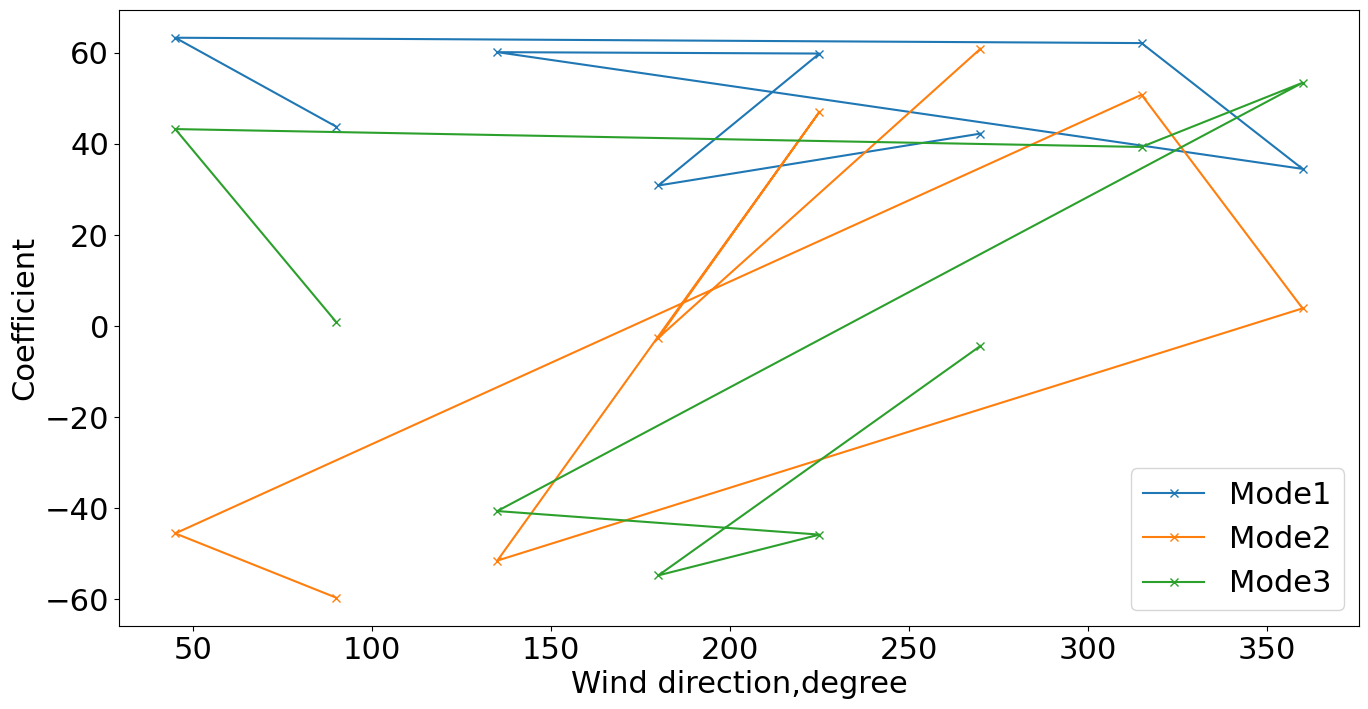

In [313]:
#tcoeff #modes x wind_direction
plt.figure(figsize=(16,8))
for i in range(3): #6
    plt.plot(data,tcoeff[i,:],'x-',label='Mode'+str(i+1))
plt.xlabel('Wind direction,degree')
plt.ylabel('Coefficient')
plt.legend()  
plt.savefig('./Results/coeff_vs_wd.png')
plt.savefig('./Results/coeff_vs_wd.pdf')

StructuredGrid (0x7fb2df6e0400)
  N Cells:      117649
  N Points:     125000
  X Bounds:     9.800e+02, 1.980e+03
  Y Bounds:     -2.570e+03, -1.670e+03
  Z Bounds:     1.656e+01, 3.000e+02
  Dimensions:   50, 50, 50
  N Arrays:     10

In [333]:
grid_structured

StructuredGrid (0x7fb3444f0c40)
  N Cells:      117649
  N Points:     125000
  X Bounds:     9.800e+02, 1.980e+03
  Y Bounds:     -2.570e+03, -1.670e+03
  Z Bounds:     1.656e+01, 3.000e+02
  Dimensions:   50, 50, 50
  N Arrays:     10

In [42]:
nr

6

# Create nr number of Rbf interpolator models for each of the nr modes.
    ## For a given wind direction, the RBf models are used to compute the Coefficient for each basis. 

In [314]:
import numpy as np
from scipy.interpolate import Rbf
import pickle


# Create Rbf interpolators for each mode. Then 
interpolators = []
for i in range(nr):
    rbf = Rbf(xsin1,xcos1,tcoeff[i,:],function='multiquadric') 
    interpolators.append(rbf)

# Save the Rbf interpolators to a file
with open('./Results/'+folder+'/rbf_interpolators.pkl', 'wb') as file:
    pickle.dump(interpolators, file)

# Load the Rbf interpolators from a file
with open('./Results/'+folder+'/rbf_interpolators.pkl', 'rb') as file:
    loaded_interpolators = pickle.load(file)

# Interpolate using the loaded interpolators (for demonstration)

predicted_values = []
for i, rbf in enumerate(loaded_interpolators):
    predicted_values.append(rbf(xsin1,xcos1))

# The 'predicted_values' list now contains the interpolated values using the loaded interpolators.


np.array(predicted_values)

# Plot temporal coefficients : check RBF interpolation

import inspect
print(inspect.getargspec(plt.legend))  

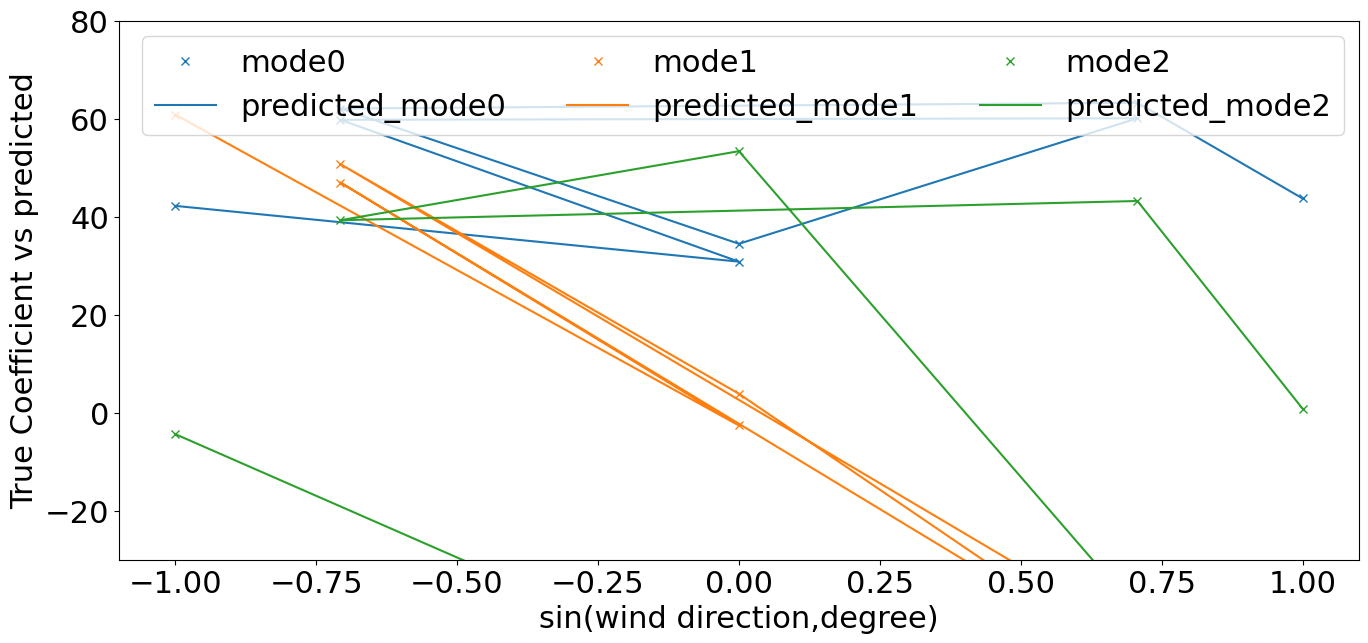

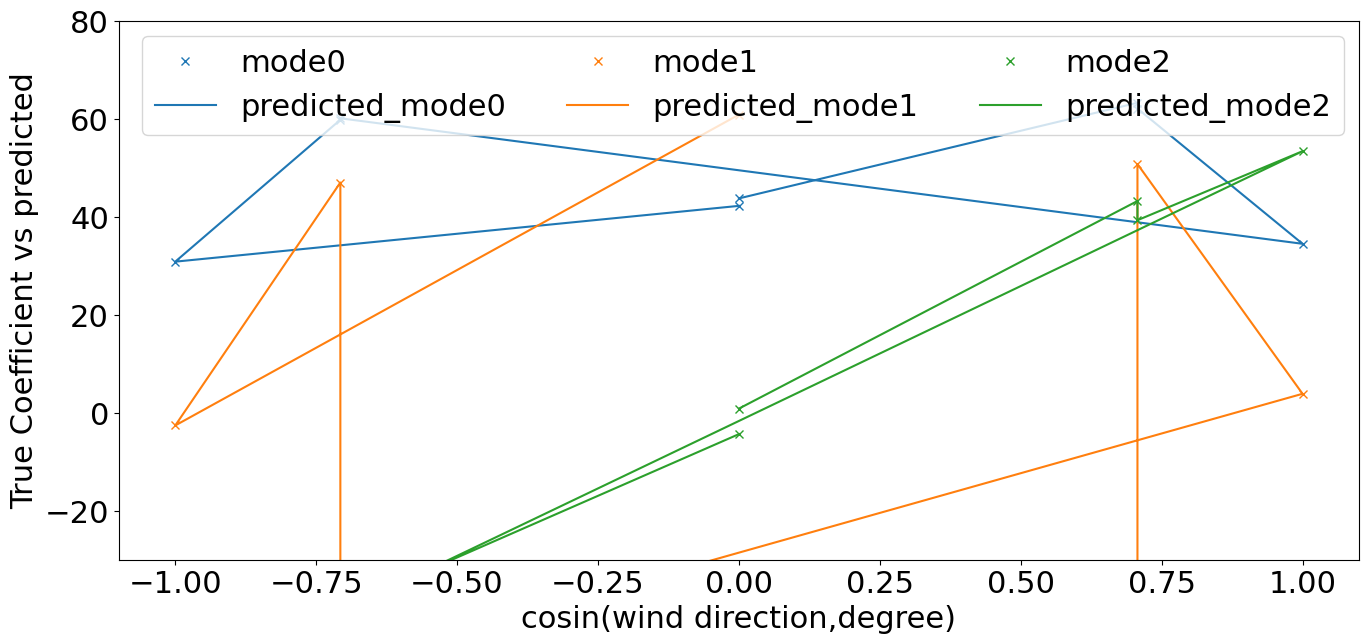

In [315]:
plt.figure(figsize=(16,7))
for i in range(3):
    plt.plot(xsin1,tcoeff[i,:],'x',label='mode'+str(i))
    plt.plot(xsin1,np.array(predicted_values)[i,:],color=plt.gca().lines[-1].get_color(),label='predicted_mode'+str(i))
plt.xlabel('sin(wind direction,degree)')
plt.ylabel('True Coefficient vs predicted')
plt.ylim((-30,80))
plt.legend(loc='upper right',ncol=3)

plt.figure(figsize=(16,7))
for i in range(3):
    plt.plot(xcos1,tcoeff[i,:],'x',label='mode'+str(i))
    plt.plot(xcos1,np.array(predicted_values)[i,:],label='predicted_mode'+str(i),color=plt.gca().lines[-1].get_color())
plt.xlabel('cosin(wind direction,degree)')
plt.ylabel('True Coefficient vs predicted')
plt.ylim((-30,80))
plt.legend(loc='upper right',ncol=3)

# Reconstruct flow field for a given wind direction

In [347]:
import time
start = time.process_time()
# your code here    

# Assume a wind direction 
# wind_dir=np.rand270 #in degrees
import random

wind_direc = [random.randint(0, 360) for _ in range(5)]
print(wind_direc)

folder = 'data_POD'




# Load the Rbf interpolators from a file
with open('./Results/'+folder+'/rbf_interpolators.pkl', 'rb') as file:
    loaded_interpolators = pickle.load(file)
    
#Obtain basis functions
#----------------------------------------------------------------------------------------------------

#Load saved basis functions (modes) and mean turbulent kinetic energy
    
filename = './Results/'+folder+'/POD_data_k.npz' #A NpzFile is a dictionary-like object.Query with the .files attribute) and for the arrays themselves.

PODdata=np.load(filename)

Phit=PODdata['tbasis']
tke_mean=PODdata['tmean']    

for wind_dir in wind_direc:  
    
    
    #Obtain coefficient for this wind direction
    #------------------------------------------------------------------  
    # Interpolate using the loaded interpolators (for demonstration)
    predicted_coef = []
    max_value=360
    xsin_winddir=np.sin(2 * np.pi * wind_dir / max_value)
    xcos_winddir=np.cos(2 * np.pi * wind_dir / max_value)
    for i, rbf1 in enumerate(loaded_interpolators):
        predicted_coef.append(rbf1(xsin_winddir,xcos_winddir))
        print('Coeff for mode', i+1 , 'is ', rbf1(xsin_winddir,xcos_winddir))





    #Reconstruct flow field from the basis modes, the mean and the computed coefficients
    #----------------------------------------------------------------------------------------------------
    tke_at_wind_direction=np.dot(Phit,np.array(predicted_coef))+tke_mean

    #Visualize reconstructed flow field.
    #----------------------------------------------------------------------------------------------------
    result_sample.point_data["RECON_tke_at_WD_"+str(wind_dir)]=tke_at_wind_direction


#Print time taken
print(time.process_time() - start)

[303, 83, 225, 160, 67]
Coeff for mode 1 is  59.80143924045683
Coeff for mode 2 is  56.746125700859274
Coeff for mode 3 is  29.974941919576978
Coeff for mode 4 is  -9.1812687314914
Coeff for mode 5 is  -3.1613374003193258
Coeff for mode 6 is  10.342201434614616
Coeff for mode 7 is  1.4447907535130113
Coeff for mode 8 is  -4.666735646487481
Coeff for mode 1 is  45.23208773968099
Coeff for mode 2 is  -58.932524657295275
Coeff for mode 3 is  8.469378628144867
Coeff for mode 4 is  -23.075475307206375
Coeff for mode 5 is  11.956272109928477
Coeff for mode 6 is  -2.908472126054754
Coeff for mode 7 is  6.193776794087768
Coeff for mode 8 is  -0.7369581130891021
Coeff for mode 1 is  59.78352737426758
Coeff for mode 2 is  46.98127365112303
Coeff for mode 3 is  -45.78006744384766
Coeff for mode 4 is  0.8641278147697449
Coeff for mode 5 is  -9.013934135437069
Coeff for mode 6 is  -10.311088562011719
Coeff for mode 7 is  3.698950290679903
Coeff for mode 8 is  4.18351411819458
Coeff for mode 1 is  4

In [348]:
result_sample

StructuredGrid (0x7fb3444f0d60)
  N Cells:      117649
  N Points:     125000
  X Bounds:     9.800e+02, 1.980e+03
  Y Bounds:     -2.570e+03, -1.670e+03
  Z Bounds:     1.656e+01, 3.000e+02
  Dimensions:   50, 50, 50
  N Arrays:     14

In [349]:
Phit.shape

(125000, 8)

In [350]:
PODdata.files

['tmean', 'tbasis', 'tcoeff', 'teigenvalues', 'tric']

In [351]:
result_sample.point_data_to_cell_data()

StructuredGrid (0x7fb2df6a09a0)
  N Cells:      117649
  N Points:     125000
  X Bounds:     9.800e+02, 1.980e+03
  Y Bounds:     -2.570e+03, -1.670e+03
  Z Bounds:     1.656e+01, 3.000e+02
  Dimensions:   50, 50, 50
  N Arrays:     14

# SAVE VTK files with POD modes and Reconstructions for visualization

In [352]:
result_sample.save('./Results/recon_added.vtk')

In [336]:
tke_at_wind_direction.shape

(125000,)

# ENDS HERE

#  ---------------------------------------------------------------------------------------

#  ----------------------------------------------------------------------------------

##### Not needed below: Testing time needed if one does not load and save the modes, but just reconstructs. About 0.09 s.